In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

loading in the dataset

In [4]:
global_temp_byCountry = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

In [5]:
global_temp_byCountry['dt'] = pd.to_datetime(global_temp_byCountry['dt'])
global_temp_byCountry['Year'] = global_temp_byCountry['dt'].dt.year
#dropping null values
global_temp_byCountry=global_temp_byCountry.dropna()

#initialising two null numpy arrays
avg_temp = np.array([])
year = np.array([],dtype=int)


#using iterrows to create two numpy arrays with average temperature and year respectively
for index,row in global_temp_byCountry.iterrows():
    if row['Country']=='United States':
        avg_temp = np.append(avg_temp,row['AverageTemperature'])
        year = np.append(year,row['Year'])
        

Creating a dataframe using the two numpy arrays using the zip function

In [6]:

master_array = zip(avg_temp,year)
data = pd.DataFrame(master_array,columns=['AverageTemperature','Year'])    

In [7]:
#grouping by the max and min temperatures by decade
maxTemps = data.groupby((data['Year']//10)*10)['AverageTemperature'].max().reset_index()
maxTemps= maxTemps.rename(columns={"AverageTemperature": "MaxTemperature"})

minTemps = data.groupby((data['Year']//10)*10)['AverageTemperature'].min().reset_index()
minTemps= minTemps.rename(columns={"AverageTemperature": "MinTemperature"})


In [8]:
#merging the two datasets and selecting out where the year is greater than 1900
MaxMinTemp = maxTemps.merge(minTemps,how='right',left_on='Year',right_on='Year')
MaxMinTemp = MaxMinTemp[MaxMinTemp['Year']>1900]

# Plotting a bar chart illustrating the max and min temperatures per decade since 1900 in the US

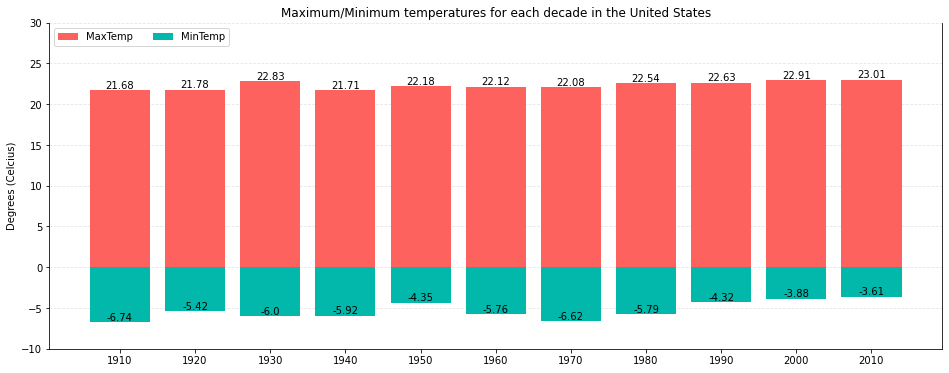

In [9]:
fig, ax = plt.subplots(1, figsize=(16, 6))
plt.bar(MaxMinTemp['Year'], MaxMinTemp['MaxTemperature'], width = 8, color = '#fd625e')
plt.bar(MaxMinTemp['Year'], MaxMinTemp['MinTemperature'], width = 8, color = '#01b8aa')

# remove spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(False)


plt.ylabel('Degrees (Celcius)')
plt.xticks(MaxMinTemp['Year'])

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)

#the values of each bar, rounding to 2 decimal places
labels = round(pd.concat([MaxMinTemp['MaxTemperature'],MaxMinTemp['MinTemperature']]),2)

#plotting the values of each bar on top of the bar
for r, label in zip(ax.patches, labels):
    height = r.get_height()
    ax.text(r.get_x() + r.get_width() / 2, height, label, ha="center", va="bottom")

plt.ylim(-10, 30)
plt.title('Maximum/Minimum temperatures for each decade in the United States')
plt.legend(['MaxTemp', 'MinTemp'], loc='upper left', ncol = 2)
plt.savefig('maxminTemp.png', bbox_inches='tight')
plt.show()

# Plotting number of temperature anomalies for each decade in Russia

Note: Temperature anomaly is when the registered temperature is 2 degrees higher or lower than the mean for that specfic time of the year, where the mean is measured over a sustained period of time (i.e 40 years)

In [10]:
global_temp_byCountry['dt'] = pd.to_datetime(global_temp_byCountry['dt'])
global_temp_byCountry['Year'] = global_temp_byCountry['dt'].dt.year
global_temp_byCountry=global_temp_byCountry.dropna()

#selecint out data for Russia specifically
anom_data= global_temp_byCountry[global_temp_byCountry['Country']=='Russia']

anom_data=anom_data[anom_data['dt']>'1900-01-01']

In [11]:
anom_data=anom_data[(anom_data['Year']>=1950) & (anom_data['Year']<2010)]

#calculating the mean for each month of the year
monthly_mean=anom_data.groupby((anom_data['dt'].dt.month))['AverageTemperature'].mean().reset_index()
monthly_mean=monthly_mean.rename(columns={'dt':'month','AverageTemperature':'monthly_mean'})

#using a right join to merge the monthly mean to the dataframe
anom_data=anom_data.merge(monthly_mean,how='right',left_on=anom_data['dt'].dt.month,right_on='month')

#initialising the anomaly column as 0, this will serve as an anomaly indicator, where 1 is max anomaly, 
#2 is min anomaly
anom_data['Anomaly'] = 0

to calculate the temperature anomalies I want to firstly calculate the difference between the temperature and the average temperature for that month. I will then use an if block to check if this difference is >=2 or <=2.

In [12]:
for index,rows in anom_data.iterrows():
    diff = rows['AverageTemperature'] - (rows['monthly_mean'])
    if diff >= 2:
        anom_data.iloc[index,7] = 1
    elif diff <=-2:
        anom_data.iloc[index,7] = 2


In [13]:
#seperating based on "type" of anomaly
max_anom = anom_data[anom_data['Anomaly']==1]
min_anom = anom_data[anom_data['Anomaly']==2]

In [14]:
#grouping anomalies by decade in which they occurred and getting a count of each decade

max_count = max_anom.groupby((max_anom['Year']//10)*10)['Anomaly'].count().reset_index()
min_count = min_anom.groupby((min_anom['Year']//10)*10)['Anomaly'].count().reset_index()
max_count= max_count.rename(columns={'Anomaly':'max_anom_count'})
min_count= min_count.rename(columns={'Anomaly':'min_anom_count'})

maxmin_anom = max_count.merge(min_count,how='right',left_on='Year',right_on='Year')
maxmin_anom

,Year,max_anom_count,min_anom_count
0,1950,4,17
1,1960,6,17
2,1970,4,14
3,1980,12,11
4,1990,19,5
5,2000,22,5


# Illustrating anomalies as bar plot

<ipython-input-15-3a349ff6cc0d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


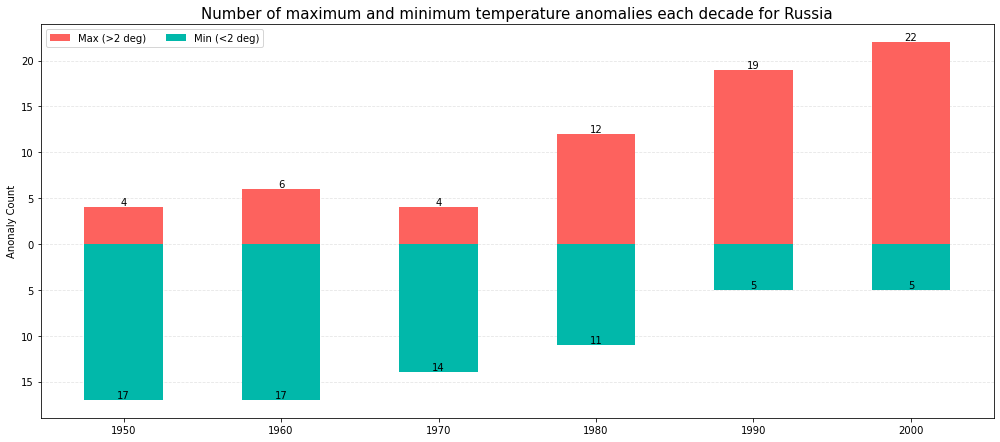

In [15]:
fig, ax = plt.subplots(1, figsize=(14, 6))
plt.bar(maxmin_anom['Year'], maxmin_anom['max_anom_count'], width = 5, color = '#fd625e')
plt.bar(maxmin_anom['Year'], -1*maxmin_anom['min_anom_count'], width = 5, color = '#01b8aa')

plt.ylabel('Anonaly Count')
plt.xticks(maxmin_anom['Year'])

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)
#ax.set_xticks(ax.get_xticks()[::2]) 
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])

labels = pd.concat([maxmin_anom['max_anom_count'],maxmin_anom['min_anom_count']])

#plotting the values of each bar on top of the bar
for r, label in zip(ax.patches, labels):
    height = r.get_height()
    ax.text(r.get_x() + r.get_width() / 2, height, label, ha="center", va="bottom")

plt.tight_layout()
plt.title('Number of maximum and minimum temperature anomalies each decade for Russia',size=15)
plt.legend(['Max (>2 deg)', 'Min (<2 deg)'], loc='upper left', ncol = 2)
plt.savefig('Anomalies.png', bbox_inches='tight')
plt.show()

In [17]:


global_temp_byCountry = pd.read_csv("GlobalLandTemperaturesByCity.csv")




In [18]:
len(global_temp_byCountry)

8599212

In [20]:
global_temp_byCountry.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
